In [1]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [2]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 2

image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


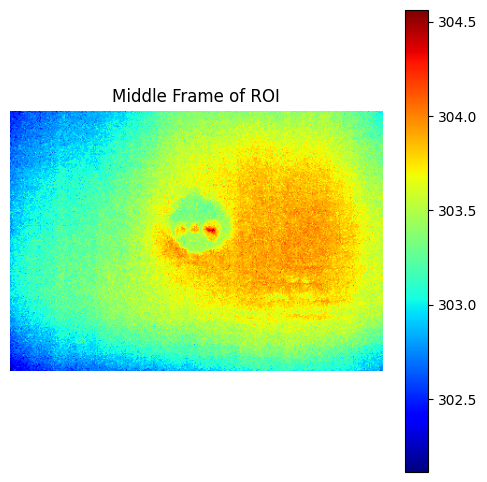

In [3]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

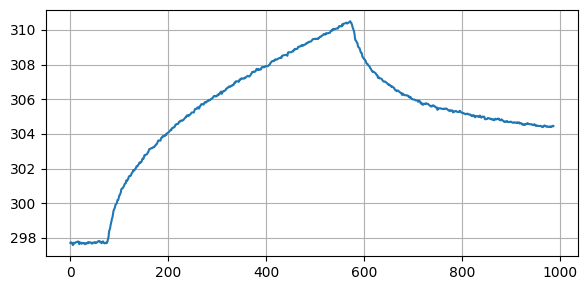

91


In [4]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,13:1000])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 80

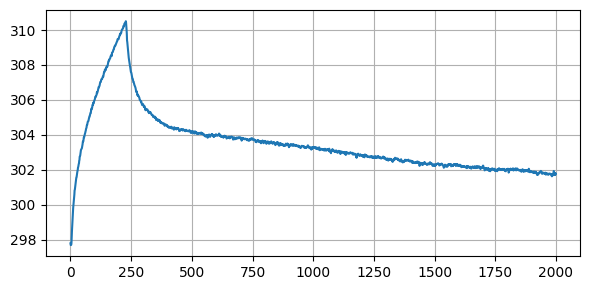

In [5]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

U, S, Vh = np.linalg.svd(imageMatrix, full_matrices=False)

Vh = Vh[:n_components, :]

principal_comp = np.matmul(imageMatrix, Vh.T)

pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

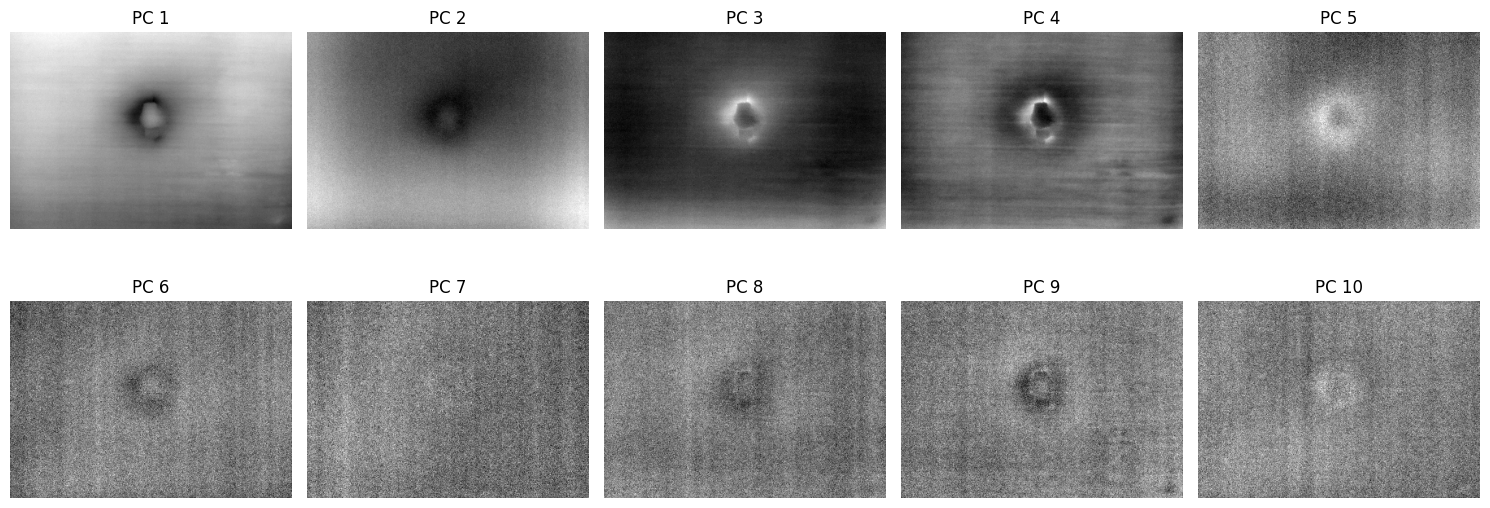

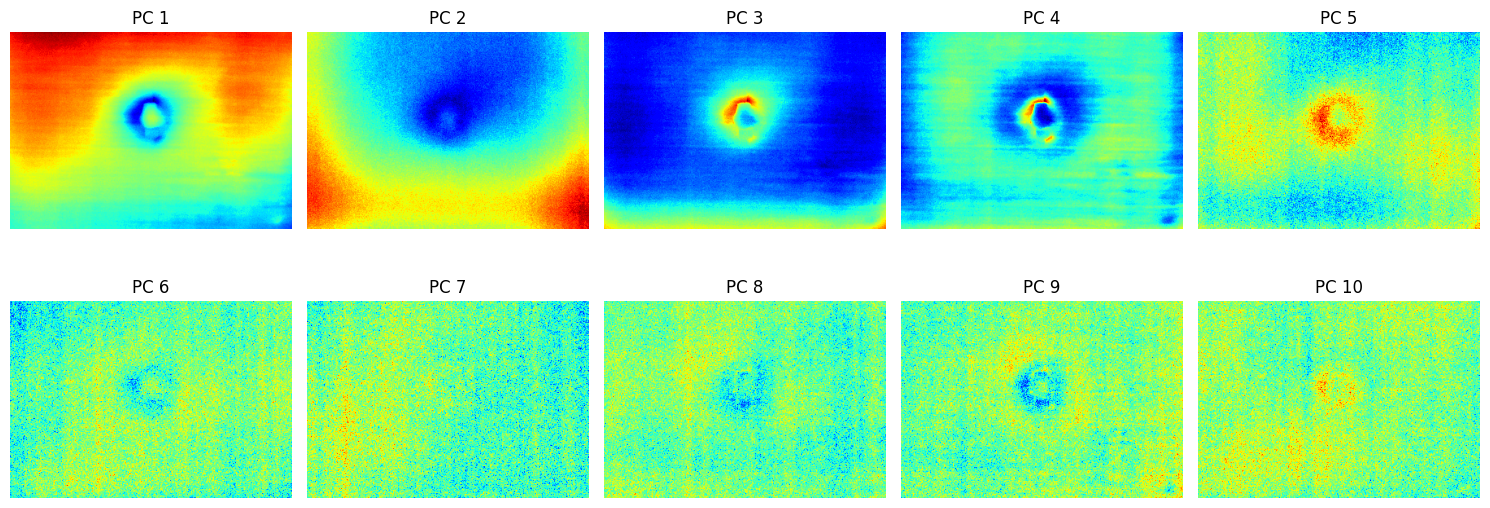

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

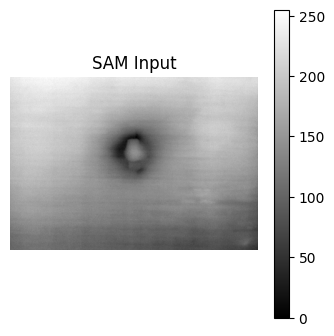

In [ ]:
import torch
import cv2
import numpy as np
import os

comp = pca_array[0, :, :]

comp -= comp.min()
comp /= (comp.max() + 1e-8)
comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.show()

In [9]:
import re, json, torch, numpy as np, cv2, matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import AutoModelForCausalLM, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained("lmsys/vicuna-7b-v1.5", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    "THUDM/cogvlm-grounding-generalist-hf",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
).eval()

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 8/8 [00:55<00:00,  6.94s/it]


In [10]:
query = 'Locate the defects in this thermal image. Detect each defect and describe its type, size, and location.'

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

conv = model.build_conversation_input_ids(tokenizer, query=query, images=[image])

inputs = {"input_ids": conv["input_ids"].unsqueeze(0),
          "attention_mask": conv["attention_mask"].unsqueeze(0)}
if conv.get("token_type_ids") is not None:
    inputs["token_type_ids"] = conv["token_type_ids"].unsqueeze(0)
imgs = conv.get("images", None)
if imgs is not None and len(imgs) > 0 and imgs[0] is not None:
    t = imgs[0][0] if isinstance(imgs[0], list) and len(imgs[0]) > 0 else imgs[0]
    inputs["images"] = [[t.to(dtype=torch.float16)]]

with torch.inference_mode():
    out = model.generate(**inputs, max_length=2048, do_sample=False)
    out = out[:, inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(out[0], skip_special_tokens=True)

m = re.search(r"\{.*\}", text, flags=re.S)
boxes_rel = []
if m:
    try:
        boxes_rel = json.loads(m.group(0)).get("boxes", [])
    except:
        boxes_rel = []
if not boxes_rel:
    arr = re.findall(r"\[\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\](?:\s*,\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\]\s*)*\s*\]", text)
    if arr:
        try:
            boxes_rel = json.loads(arr[0])
        except:
            boxes_rel = []

boxes_px = []
for b in boxes_rel:
    if isinstance(b, (list, tuple)) and len(b) == 4:
        x1 = int(round(b[0] / 1000.0 * W)); y1 = int(round(b[1] / 1000.0 * H))
        x2 = int(round(b[2] / 1000.0 * W)); y2 = int(round(b[3] / 1000.0 * H))
        if x2 > x1 and y2 > y1:
            boxes_px.append((x1, y1, x2, y2))

img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for (x1, y1, x2, y2) in boxes_px:
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"{len(boxes_px)} box(es)")
plt.show()

print(text)
print("boxes (0–1000):", boxes_rel)
print("boxes (pixels):", boxes_px)

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/transformers/generation/utils.py:2505: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'shape'